<a href="https://colab.research.google.com/github/ssufian/DAT-612/blob/master/DAT_612_Final_Project_S_Sufian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT 612 Final Project 
Compare the accuracy of at least two recommender system algorithms against an offline data

This project will use the data tables from the 2 MovieLens data sets; ratings and movies tables 

Reference 1:
- Movielens Data source was downloaded from Kaggle website: https://www.kaggle.com/prajitdatta/movielens-100k-dataset?

In [ ]:
#Loading libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from shapely.geometry import Point, Polygon
%matplotlib inline
from scipy.sparse.linalg import svds
from numpy.linalg import svd
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from math import sqrt
!pip3 install surprise 
import sklearn
!pip3 install Turicreate
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict
import warnings
from sklearn.metrics.pairwise import pairwise_distances 
warnings.filterwarnings("ignore")


#from IPython.core.magic import line_magic, line_cell_magic, Magics, magics_class
#from pyspark.ml.evaluation import RegressionEvaluator
#from pyspark.ml.recommendation import ALS
#from pyspark.sql import Row
#import findspark
#from pyspark import SparkContext
#from pyspark import SparkConf
#from pyspark.sql import *
#from pyspark.sql.functions import *
#from pyspark.mllib.linalg import Vectors
#from pyspark.mllib.linalg.distributed import RowMatrix
#from pyspark.context import SparkContext
#from pyspark.sql.session import SparkSession
#install_requires=['pyspark=={site.SPARK_VERSION}']
#from pyspark.sql.functions import *
#sc = SparkContext('local')
#spark = SparkSession(sc)


In [ ]:
#spark.stop() # disconnect Spark

# Loading data tables

- Arranging the ratings & Movies tables and preparing the columns for different genres of movie types

In [5]:

df = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/ratings.csv')
df.shape
df.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [6]:
movies = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/movies.csv')
#movies1 = movies1.rename(columns = {'movieId':'user_id'})
movies.head()
#movies.shape

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Basic Data Preparation
- Basic Exploratory analysis

In [ ]:
# merge on movieId=user_id column
data = pd.merge(left=movies, right=df, on='movieId')

In [ ]:
data.head(6)
data.shape

(1048575, 5)

In [ ]:
#checking for N/As
data.isnull().sum()

movieId    0
title      0
genres     0
userId     0
rating     0
dtype: int64

In [ ]:
data.shape

(1048575, 5)

In [ ]:
#checking for no. of unique movies

data['movieId'].nunique()

22240

In [ ]:
years = []

for title in data['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
        
data['moviePubYear'] = years
print(len(data[data['moviePubYear'] == 9999]))

555


In [ ]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        dataset = dataset[dataset['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(dataset[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)

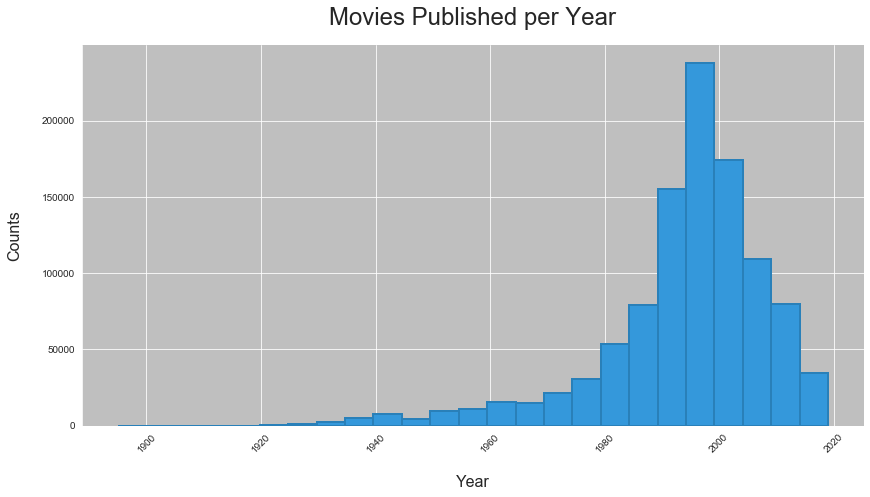

In [ ]:
make_histogram(data, 'moviePubYear', title='Movies Published per Year', xlab='Year', ylab='Counts')

# The number of  Latent Factors needed for Truncated SVD

In [ ]:
#This is just to show how many genres are there to create the number of needed latent Factors for Truncated SVD model
columns1 = ['movieId', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
          'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_to_show_genres = pd.read_csv('https://raw.githubusercontent.com/ssufian/DAT-612/master/Projects/datasets_626_1187_ml-100k_u%20(2).item', sep='|', names=columns1, 
                     encoding='latin-1')
movies_to_show_genres.head()


,movieId,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movie_names = movies[['movieId', 'title']]
combined_movies_data = pd.merge(df, movie_names, on='movieId')
combined_movies_data.head()
#combined_movies_data.shape

,userId,movieId,rating,title
0,1,296,5.0,Pulp Fiction (1994)
1,3,296,5.0,Pulp Fiction (1994)
2,4,296,4.0,Pulp Fiction (1994)
3,5,296,4.0,Pulp Fiction (1994)
4,7,296,4.0,Pulp Fiction (1994)


# Pivot data

- Create a user-item table

In [ ]:
rating_crosstab = combined_movies_data.pivot_table(values='rating', index='userId', columns='title', fill_value=0)
rating_crosstab

title,"""Great Performances"" Cats (1998)",#realityhigh (2017),$ (Dollars) (1971),$5 a Day (2008),$9.99 (2008),'71 (2014),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'R Xmas (2001),'Round Midnight (1986),...,Когда зажигаются ёлки (1950),Ландыш серебристый (2000),Мартынко (1987),Мафия (2016),Начальник,Обезьянки и грабители (1985),Он вам не Димон (2017),Приключения Домовёнка (1986),Принцесса и Людоед (1977),Я худею (2018)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
3,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
4,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
5,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7041,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
7042,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0
7043,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0


In [ ]:
rating_crosstab.shape

(7045, 22226)

# Transposing Table 
- Making an Item-Item based Table
- Transpose of Utility Matrix makes rows into movies & columns into users

In [ ]:
#Transpose of Utility Matrix => IBCF
X = rating_crosstab.T
X.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#realityhigh (2017),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$ (Dollars) (1971),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$5 a Day (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Truncated SVD
- Using Scikit-Learn to easily run the SVD decomposition into 20 latent factors, i.e. 20 different genre types

In [ ]:
SVD = TruncatedSVD(n_components=20, random_state=5)
US = SVD.fit_transform(X)

In [ ]:
# Components of Truncated SVD decompositions
V=SVD.components_
S=SVD.singular_values_ 
#print('u,s,v', US,S,V)
#print('Check if Original Matrix is Restored: ',np.round(np.dot(US,V),1))

In [ ]:
print(SVD.explained_variance_ratio_)

print(SVD.explained_variance_ratio_.sum())

print(SVD.singular_values_)

[0.1709174  0.04140253 0.02255414 0.01834604 0.01310275 0.01220618
 0.01210197 0.00830934 0.00737258 0.00600195 0.00574421 0.00561532
 0.00536161 0.00486189 0.00425913 0.00399123 0.00374156 0.00358006
 0.00342113 0.00329635]
0.3561873697217518
[1623.53535391  761.24674545  565.52498996  521.72269688  441.82085645
  413.43904458  413.30138241  341.17367404  321.89482556  290.32837432
  285.32396543  280.80937009  273.9052148   260.82560568  244.38848083
  236.9936827   230.5757045   224.61823943  220.74940192  214.8897386 ]


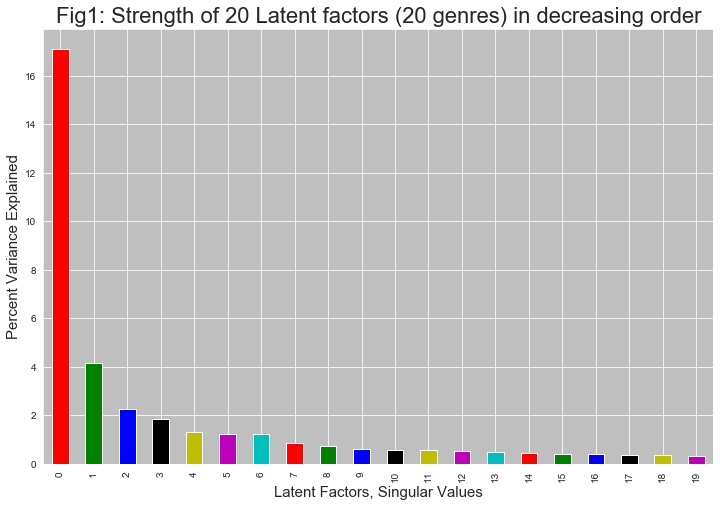

In [ ]:
# converting matrix to dataframe for plotting purposes only
var_ = pd.DataFrame(SVD.explained_variance_ratio_*100)
var_.columns = ['variance']
var_.index.names = ['factors']
#setting plot size
plt.rcParams['figure.figsize']=(12,8)
my_colors = 'rgbkymc'    
sns.set_style("darkgrid",{"axes.facecolor": ".75"}) 
 
var_[:20].plot(kind="bar",color=my_colors)
plt.legend('',frameon=False)
plt.xticks(rotation=90, horizontalalignment="center")
plt.title("Fig1: Strength of 20 Latent factors (20 genres) in decreasing order", fontsize=22)
plt.xlabel("Latent Factors, Singular Values",fontsize=15)
plt.ylabel("Percent Variance Explained",fontsize=15)
plt.show()

In [ ]:
### correlation matrix to actually visualize which movies correlates with another; less efficient
#corr_mat_X=US.T.corr()
#corr_mat_X.head()
US

array([[ 1.03999361e+00,  6.59899619e-01,  4.56851990e-02, ...,
        -7.42280488e-01,  8.51182425e-01,  8.03658721e-01],
       [ 4.36584337e-01, -2.57259969e-01,  3.52953799e-01, ...,
         4.68565292e-01, -3.53375020e-01,  3.73515399e-01],
       [ 1.25437438e+01,  5.66918773e+00, -4.90783765e+00, ...,
        -1.24421361e+00,  1.22044390e-01,  2.35042437e+00],
       ...,
       [ 3.58929614e-01,  3.71252154e-01,  2.29697499e-02, ...,
        -2.21450649e-01,  5.66742101e-01,  3.78227779e-01],
       [ 1.42428013e+00,  8.14959981e-01, -4.90234264e-01, ...,
        -7.25062938e-01,  2.67599945e-01, -2.06811026e-01],
       [ 2.29210339e-01, -6.22453482e-03,  2.73168483e-01, ...,
         6.53523560e-01, -5.85882428e-02, -3.44356910e-02]])

In [ ]:
#Correlation Matrix based on Truncated SVD with K=20
corr_mat = np.corrcoef(US)
corr_mat

array([[ 1.        , -0.16892649,  0.24622301, ...,  0.27841894,
         0.49655912,  0.02549195],
       [-0.16892649,  1.        ,  0.03658684, ...,  0.00485752,
         0.22477219,  0.49050534],
       [ 0.24622301,  0.03658684,  1.        , ...,  0.67882604,
         0.2815439 , -0.02353832],
       ...,
       [ 0.27841894,  0.00485752,  0.67882604, ...,  1.        ,
         0.1351043 , -0.17398341],
       [ 0.49655912,  0.22477219,  0.2815439 , ...,  0.1351043 ,
         1.        , -0.00922123],
       [ 0.02549195,  0.49050534, -0.02353832, ..., -0.17398341,
        -0.00922123,  1.        ]])

In [ ]:
# Function to check for similar movies
def get_similar_item(movie):
    movie_input =str(movie)
    col_idx = rating_crosstab.columns.get_loc(movie_input)
    corr_specific = corr_mat[col_idx]
    df_similar_movie=pd.DataFrame({'corr_specific':corr_specific, 'Movies': rating_crosstab.columns})\
    .sort_values('corr_specific', ascending=False).head(10)# selecting only Top 10 similar movies
    return print(df_similar_movie)

In [ ]:
# Check to see if similar movies are what it should be or not
check_similar_movie=get_similar_item("Pulp Fiction (1994)")

      corr_specific                            Movies
1190       1.000000               Pulp Fiction (1994)
1572       0.950869        Usual Suspects, The (1995)
1329       0.948298  Silence of the Lambs, The (1991)
1301       0.920992              Seven (Se7en) (1995)
1183       0.913683          Professional, The (1994)
1231       0.912845             Reservoir Dogs (1992)
1205       0.910766    Raiders of the Lost Ark (1981)
570        0.908905              Fugitive, The (1993)
591        0.908807                 Get Shorty (1995)
623        0.908359                 GoodFellas (1990)


In [ ]:

sc.stop()

In [ ]:
#calculate the number of unique users and movies.
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
n_items

1682

In [ ]:

df_ratings

,user_id,item_id,rating,movie title
0,101,242,2,Toy Story
1,102,302,1,GoldenEye
2,103,377,5,Four Rooms
3,104,51,1,Get Shorty
4,105,8,5,Copycat


In [ ]:
#create np array for the ratings matrix
data_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
    #print(line)
data_matrix

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
x_original#IBCF
xoriginal_matrix=x_original.to_numpy()#IBCF in Numpy

In [ ]:
#Distance Metric using Sckit Learn library
user_similarity = pairwise_distances(xoriginal_matrix, metric='cosine')
item_similarity = pairwise_distances(x_original.T, metric='cosine')

In [ ]:
item_similarity

array([[0.        , 0.35729759, 0.17136676, 0.21417472, 0.54426728],
       [0.35729759, 0.        , 0.3706055 , 0.33791529, 0.25961259],
       [0.17136676, 0.3706055 , 0.        , 0.21535687, 0.25617294],
       [0.21417472, 0.33791529, 0.21535687, 0.        , 0.6044226 ],
       [0.54426728, 0.25961259, 0.25617294, 0.6044226 , 0.        ]])

In [ ]:
x_original.T.corr()#item similarity

movie title,Copycat,Four Rooms,Get Shorty,GoldenEye,Toy Story
movie title,,,,,
Copycat,1.000000,0.222817,-0.652438,-0.225113,-0.072493
Four Rooms,0.222817,1.000000,-0.078811,-0.380693,0.801246
Get Shorty,-0.652438,-0.078811,1.000000,0.086258,0.488095
GoldenEye,-0.225113,-0.380693,0.086258,1.000000,-0.460044
Toy Story,-0.072493,0.801246,0.488095,-0.460044,1.000000


In [ ]:
corr_mat12 = np.corrcoef(x_original)
corr_mat12#IBCF similarity

array([[ 1.        ,  0.22281713, -0.65243825, -0.22511258, -0.07249314],
       [ 0.22281713,  1.        , -0.07881104, -0.38069349,  0.80124558],
       [-0.65243825, -0.07881104,  1.        ,  0.08625819,  0.48809524],
       [-0.22511258, -0.38069349,  0.08625819,  1.        , -0.46004371],
       [-0.07249314,  0.80124558,  0.48809524, -0.46004371,  1.        ]])

In [ ]:
x_original.corr()#user similarity

user_id,101,102,103,104,105
user_id,,,,,
101,1.000000,0.056478,0.619292,0.506945,-0.265543
102,0.056478,1.000000,-0.577113,-0.359937,0.078736
103,0.619292,-0.577113,1.000000,0.219265,0.164448
104,0.506945,-0.359937,0.219265,1.000000,-0.903846
105,-0.265543,0.078736,0.164448,-0.903846,1.000000


In [ ]:
corr_mat13 = np.corrcoef(x_original.T)
corr_mat13#UBCF similarity

array([[ 1.        ,  0.05647825,  0.61929212,  0.50694478, -0.2655425 ],
       [ 0.05647825,  1.        , -0.57711282, -0.35993702,  0.07873622],
       [ 0.61929212, -0.57711282,  1.        ,  0.2192645 ,  0.16444838],
       [ 0.50694478, -0.35993702,  0.2192645 ,  1.        , -0.90384615],
       [-0.2655425 ,  0.07873622,  0.16444838, -0.90384615,  1.        ]])

In [ ]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [ ]:
x_original.mean(axis=1)

movie title
Copycat        2.2
Four Rooms     3.4
Get Shorty     1.4
GoldenEye      3.0
Toy Story      2.4
dtype: float64

In [ ]:
mean_user_rating=x_original.mean(axis=1)
mean_user_rating[:, np.newaxis]
mean_user_rating.shape

(5,)

In [ ]:
#user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(x_original, corr_mat12, type='item')

In [ ]:
item_prediction

,0,1,2,3,4
movie title,,,,,
Copycat,-1.348405,0.592338,2.595575,0.383832,1.576218
Four Rooms,0.319366,3.212613,1.845147,-1.465213,3.359409
Get Shorty,0.169615,1.626635,0.149795,0.007984,1.164081
GoldenEye,0.739199,1.382666,0.578494,0.428328,1.235794
Toy Story,-0.254621,3.562861,1.755038,-1.873126,3.537509


In [ ]:
item_prediction = predict(x_original, item_similarity, type='item')
item_prediction

,0,1,2,3,4
movie title,,,,,
Copycat,2.267089,2.765133,1.352340,2.262771,1.822783
Four Rooms,3.923661,3.161457,3.446213,4.284464,2.583617
Get Shorty,1.866052,0.705765,2.140409,1.425853,1.350152
GoldenEye,2.142155,2.961571,2.776472,2.237667,3.636869
Toy Story,3.768576,1.538574,3.092142,3.748464,1.087675


In [ ]:
x_original

user_id,101,102,103,104,105
movie title,,,,,
Copycat,1,0,5,2,3
Four Rooms,3,4,4,1,5
Get Shorty,0,4,0,2,1
GoldenEye,4,4,4,3,0
Toy Story,0,5,2,0,5


In [ ]:
df_ratings = pd.read_csv("C:/CUNY Folder/CUNY Summer 2020/DAT 612/Proj 4/testfile.csv",index_col=False, na_filter= False)

df_ratings.head()


,user_id,item_id,rating,movie title
0,101,242,2,Toy Story
1,102,302,1,GoldenEye
2,103,377,5,Four Rooms
3,104,51,1,Get Shorty
4,105,8,5,Copycat


In [ ]:
crosstab = df_ratings.pivot_table(values='rating', index='user_id', columns='movie title', fill_value=0)

l1=[1,3,0,4,0]
l2=[0,4,4,4,5]
l3=[5,4,0,4,2]
l4=[2,1,2,3,0]
l5=[3,5,1,0,5]

crosstab.iloc[0]=l1
crosstab.iloc[1]=l2
crosstab.iloc[2]=l3
crosstab.iloc[3]=l4
crosstab.iloc[4]=l5
crosstab

movie title,Copycat,Four Rooms,Get Shorty,GoldenEye,Toy Story
user_id,,,,,
101,1,3,0,4,0
102,0,4,4,4,5
103,5,4,0,4,2
104,2,1,2,3,0
105,3,5,1,0,5


In [ ]:
x = crosstab.T
x
x_original= x.copy()
x_original

user_id,101,102,103,104,105
movie title,,,,,
Copycat,1,0,5,2,3
Four Rooms,3,4,4,1,5
Get Shorty,0,4,0,2,1
GoldenEye,4,4,4,3,0
Toy Story,0,5,2,0,5


In [ ]:
x.replace(0, np.NaN, inplace=True)

xmean=x.mean(axis = 1, skipna = True)
xmean

movie title
Copycat        2.750000
Four Rooms     3.400000
Get Shorty     2.333333
GoldenEye      3.750000
Toy Story      4.000000
dtype: float64

In [ ]:
x.replace(np.NaN, 0, inplace=True)
x1 = x.copy()
for i in range(len(x)):
    for j in range(len(x)):
        if x.iloc[i,j]>0:
            x.iloc[i,j]=x.iloc[i,j]-xmean[i]
        else:
            x1.iloc[i,j]=x.iloc[i,j]



In [ ]:
type(x1)
x1#normalized data

user_id,101,102,103,104,105
movie title,,,,,
Copycat,-1.75,0.000000,2.25,-0.750000,0.250000
Four Rooms,-0.40,0.600000,0.60,-2.400000,1.600000
Get Shorty,0.00,1.666667,0.00,-0.333333,-1.333333
GoldenEye,0.25,0.250000,0.25,-0.750000,0.000000
Toy Story,0.00,1.000000,-2.00,0.000000,1.000000


In [ ]:
x1.T.corr()#Adjusted similarity matrix 

movie title,Copycat,Four Rooms,Get Shorty,GoldenEye,Toy Story
movie title,,,,,
Copycat,1.000000,0.473686,-0.013041,0.268373,-0.586556
Four Rooms,0.473686,1.000000,-0.050872,0.761387,0.134595
Get Shorty,-0.013041,-0.050872,1.000000,0.356348,0.062994
GoldenEye,0.268373,0.761387,0.356348,1.000000,-0.117851
Toy Story,-0.586556,0.134595,0.062994,-0.117851,1.000000


In [ ]:
x_original

user_id,101,102,103,104,105
movie title,,,,,
Copycat,1,0,5,2,3
Four Rooms,3,4,4,1,5
Get Shorty,0,4,0,2,1
GoldenEye,4,4,4,3,0
Toy Story,0,5,2,0,5


In [ ]:
#check how to use TRuncatedSVD
X11=np.array([[1,2,3],[1,4,2],[4,1,7],[5,6,8]])
print(X11)
print(X11.shape)
# TRUNCATED SVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
US1=svd.fit_transform(X11)
V1=svd.components_
S1=svd.singular_values_ 
US=svd.fit_transform(X)
print(US1)
print(US1.shape)
print(V1)
print(V1.shape)
print(S1)
print(S1.shape)
sigma = np.diag(S1)
R_hat = np.dot(np.dot(US1, V1),1)
print(R_hat)
sigma

[[1 2 3]
 [1 4 2]
 [4 1 7]
 [5 6 8]]
(4, 3)
[[ 3.66997034 -0.34754761]
 [ 3.82764223 -2.51681397]
 [ 7.61154768  2.83860088]
 [11.13470337 -0.96070751]]
(4, 2)
[[ 0.44571865  0.46215842  0.76664495]
 [ 0.23882889 -0.88677195  0.39572247]]
(2, 3)
[14.49264657  3.92883644]
(2,)
[[1.5527698  2.00430316 2.67603185]
 [1.10496362 4.00081711 1.93848276]
 [4.07054862 1.0005492  6.95865276]
 [4.7335002  5.99792537 8.1561906 ]]


array([[14.49264657,  0.        ],
       [ 0.        ,  3.92883644]])

In [ ]:
sc.stop()